# Data Exploration & experimentation

Explore the LBMP data and experiment with forecasting models. 

## Imports and inputs

In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import copy
import functools
import itertools
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly

import os
import glob

pd.options.display.max_columns=None
plotly.offline.init_notebook_mode(True)

In [2]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
import xgboost
from sklearn.multioutput import MultiOutputRegressor

In [3]:
from src.features import create_features, read_data, preprocess_data
from src.models import XgbWrap, SarimaWrap, ProphetWrap, split, evaluate, cv
from src.plots import plot_decomposition

In [4]:
lbmp_dirpath = "data/2017_NYISO_LBMPs"
gaspath = "data/Natural Gas Futures Historical Data.csv"
dtest = pd.Timestamp("2017-08-01 00:00:00")

## Data

In [5]:
tmp = []
for fpath in glob.glob("data/2017_NYISO_LBMPs/*/*.csv"):
    tmp.append(pd.read_csv(fpath, header=0))
lbmp = pd.concat(tmp,axis=0)
lbmp['ts'] = pd.to_datetime(lbmp['Time Stamp'])
lbmp['date'] = lbmp['ts'].dt.date

gas = pd.read_csv('data/Natural Gas Futures Historical Data.csv')
gas['date'] = pd.to_datetime(gas['Date']).dt.date
gas['vol'] = gas['Vol.'].str.replace("K","").astype(float).interpolate()

lbmp = lbmp.merge(gas[['date','Price','vol']], on = 'date', how='left')
lbmp = lbmp.fillna(method='ffill').fillna(method='bfill')

In [6]:
lbmp.head()

Time Stamp    Name   PTID  LBMP ($/MWHr)  \
0  01/01/2017 00:00  CAPITL  61757          42.06   
1  01/01/2017 00:00  CENTRL  61754          15.50   
2  01/01/2017 00:00  DUNWOD  61760          33.52   
3  01/01/2017 00:00  GENESE  61753          14.67   
4  01/01/2017 00:00     H Q  61844          11.89   

   Marginal Cost Losses ($/MWHr)  Marginal Cost Congestion ($/MWHr)  \
0                           0.68                             -29.05   
1                           0.20                              -2.98   
2                           1.13                             -20.06   
3                           0.04                              -2.31   
4                          -0.43                               0.00   

          ts        date  Price      vol  
0 2017-01-01  2017-01-01    3.5  175.525  
1 2017-01-01  2017-01-01    3.5  175.525  
2 2017-01-01  2017-01-01    3.5  175.525  
3 2017-01-01  2017-01-01    3.5  175.525  
4 2017-01-01  2017-01-01    3.5  175.525

In [7]:
lbmp.isna().sum()

Time Stamp                           0
Name                                 0
PTID                                 0
LBMP ($/MWHr)                        0
Marginal Cost Losses ($/MWHr)        0
Marginal Cost Congestion ($/MWHr)    0
ts                                   0
date                                 0
Price                                0
vol                                  0
dtype: int64

### NYC zone

In [8]:
nyc = lbmp[lbmp['Name']=='N.Y.C.']

### eda

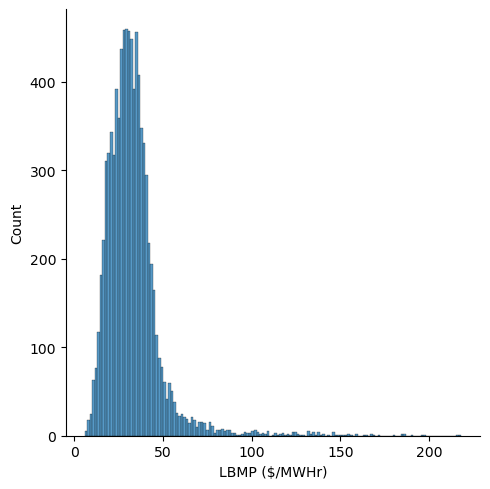

In [9]:
sns.displot(data=nyc, x='LBMP ($/MWHr)')
plt.show()

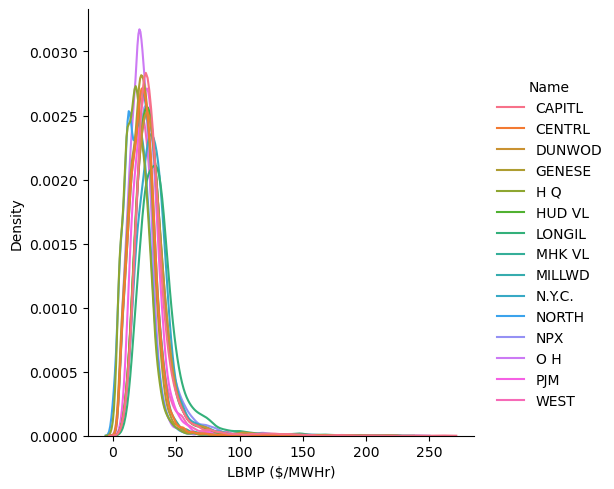

In [10]:
sns.displot(data=lbmp, x='LBMP ($/MWHr)', hue='Name', kind='kde')
plt.show()

In [11]:
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=nyc.loc[:,'ts'], y=nyc.loc[:,'LBMP ($/MWHr)'], name='LBMP', mode='lines'),
              secondary_y=False)
fig.add_trace(go.Scatter(x=nyc.loc[:,'ts'], y=nyc.loc[:,'Price'], name='GAS Price', mode='lines'),
              secondary_y=True)
fig.update_xaxes(rangeslider_visible=True)
fig.update_traces(opacity=0.7)
fig.update_layout(xaxis_title='Date', yaxis_title='LBMP', title='The LBMP and GAS price time series')
fig.show()

In [12]:
# fig.write_html("Chart1.html")

In case the above interactive chart is not rendering, look for `Chart1.html` in the repository.

### Check the intervals?

In [13]:
nyc['ts'].sort_values().diff().value_counts(dropna=False)

0 days 01:00:00    8757
NaT                   1
0 days 02:00:00       1
0 days 00:00:00       1
Name: ts, dtype: int64

just small mistakes most easily fixed manually, but here I chose more generic approach with `resample('1H)` ( every hour will be the same except those 2 anomalies)

In [14]:
tmp = nyc.set_index('ts')[['LBMP ($/MWHr)']]
tmp['lbmp_resampled'] = tmp['LBMP ($/MWHr)'].resample('1H').mean()
tmp.head()

LBMP ($/MWHr)  lbmp_resampled
ts                                                
2017-01-01 00:00:00          33.60           33.60
2017-01-01 01:00:00          32.05           32.05
2017-01-01 02:00:00          29.23           29.23
2017-01-01 03:00:00          25.02           25.02
2017-01-01 04:00:00          26.94           26.94

the anomalies:

In [15]:
tmp[tmp['LBMP ($/MWHr)']!=tmp['lbmp_resampled']]

LBMP ($/MWHr)  lbmp_resampled
ts                                                
2017-11-05 01:00:00          19.38          20.125
2017-11-05 01:00:00          20.87          20.125

In [16]:
tmp.loc['2017-03-12 00:00:00':'2017-03-12 04:00:00']

LBMP ($/MWHr)  lbmp_resampled
ts                                                
2017-03-12 00:00:00          46.55           46.55
2017-03-12 01:00:00          43.59           43.59
2017-03-12 03:00:00          40.69           40.69
2017-03-12 04:00:00          39.86           39.86

# Data preprocessing

Apply all the preprocessing (e.g. resample) to the final dataframe that will be ready for the modelling later.

In addition I add several time step and lag features to the data to use in models. 
- hour
- day of week
- quarter
- month
- dayofyear
- dayofmonth
- weekend boolean
- lagged values of orders 1, 2 and 24
- fourier terms based on hourly frequency
- constant

All of the transformations and feature engineering is finalized in the attached scripts, which I am using here

In [17]:
data = read_data(lbmp_dirpath=lbmp_dirpath, gas_filepath=gaspath, zone='N.Y.C.')
df = preprocess_data(data)

feature_cols = ['hour', 'dayofweek', 'quarter',
       'month', 'dayofyear', 'dayofmonth', 'is_wknd', 'lag_1', 'lag_2',
       'lag_24', 'sin(1,freq=H)', 'cos(1,freq=H)', 'sin(2,freq=H)',
       'cos(2,freq=H)', 'sin(3,freq=H)', 'cos(3,freq=H)', 'sin(4,freq=H)',
       'cos(4,freq=H)', 'const', 'Price', 'vol']

In [18]:
df.isna().sum()

LBMP ($/MWHr)    1
Price            0
vol              0
lbmp             0
date             0
hour             0
dayofweek        0
quarter          0
month            0
dayofyear        0
dayofmonth       0
is_wknd          0
lag_1            0
lag_2            0
lag_24           0
sin(1,freq=H)    0
cos(1,freq=H)    0
sin(2,freq=H)    0
cos(2,freq=H)    0
sin(3,freq=H)    0
cos(3,freq=H)    0
sin(4,freq=H)    0
cos(4,freq=H)    0
const            0
dtype: int64

Just to show why interpolate the 1 anomaly where an hour is missing...

In [19]:
df[['LBMP ($/MWHr)', 'lbmp']].loc['2017-03-12 00:00:00':'2017-03-12 04:00:00']

LBMP ($/MWHr)   lbmp
ts                                       
2017-03-12 00:00:00          46.55  46.55
2017-03-12 01:00:00          43.59  43.59
2017-03-12 02:00:00            NaN  42.14
2017-03-12 03:00:00          40.69  40.69
2017-03-12 04:00:00          39.86  39.86

# Stationarity, trend and seasonality

Stationary processes are easier to model and forecast. Some methods like ARIMA require stationarity of the underlying data. 

From the above graph we can clearly see daily seasonality. 

As for the trend, aside from the occasional periods with high trend, there does not seem to be longterm trend. 

To confirm my intuition lets look at the timeseries decomposition to trend, seasonal and residual parts. The following chart shows clear seasonal effect, but also the trend is relatively constant in the longterm, but with periods where the trend is significant. 


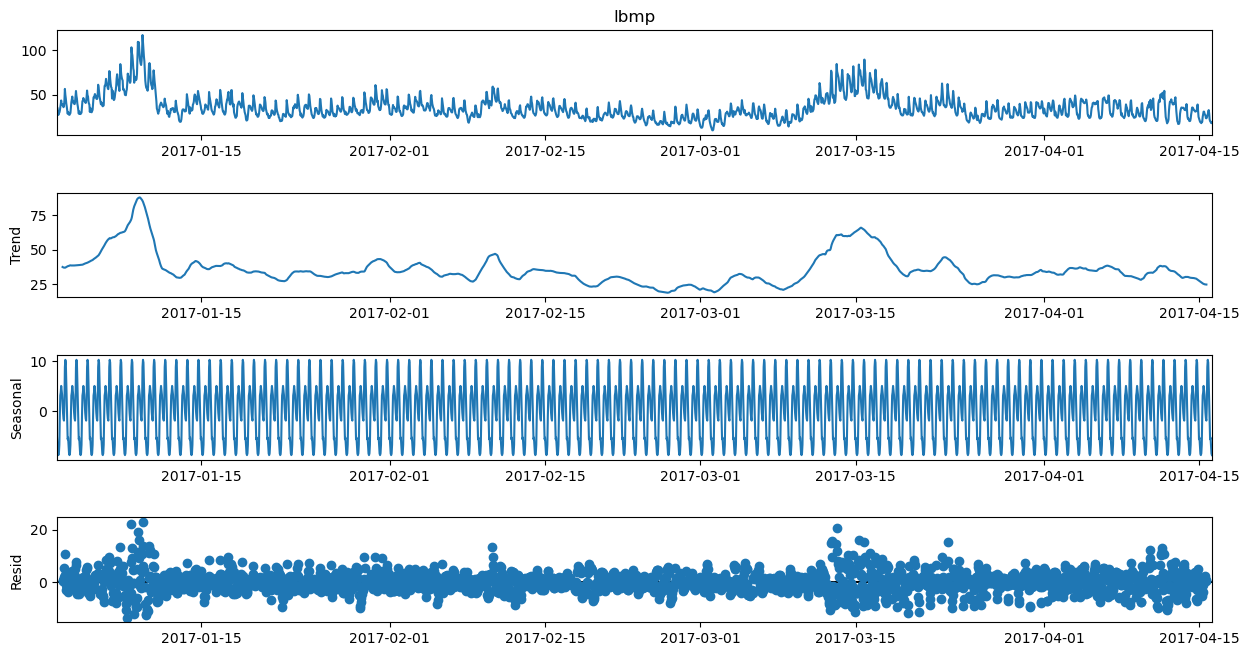

In [20]:
fig = plot_decomposition(df['lbmp'].iloc[0:2500])
fig.set_size_inches((14,7))
plt.show()

Interestingly, the whole series is stationary according to Augmented Dickey Fuller test. If the series would not be stationary, we would need to transform the series with differencing or possibly logarithm operation. 

In [21]:
dftest = sm.tsa.adfuller(df['lbmp'], autolag="AIC")
dfoutput = pd.Series(
    dftest[0:4],
    index=[
        "Test Statistic",
        "p-value",
        "#Lags Used",
        "Number of Observations Used",
    ],
)
display(dfoutput)

Test Statistic                   -4.549908
p-value                           0.000160
#Lags Used                       37.000000
Number of Observations Used    8698.000000
dtype: float64

# Autocorellation

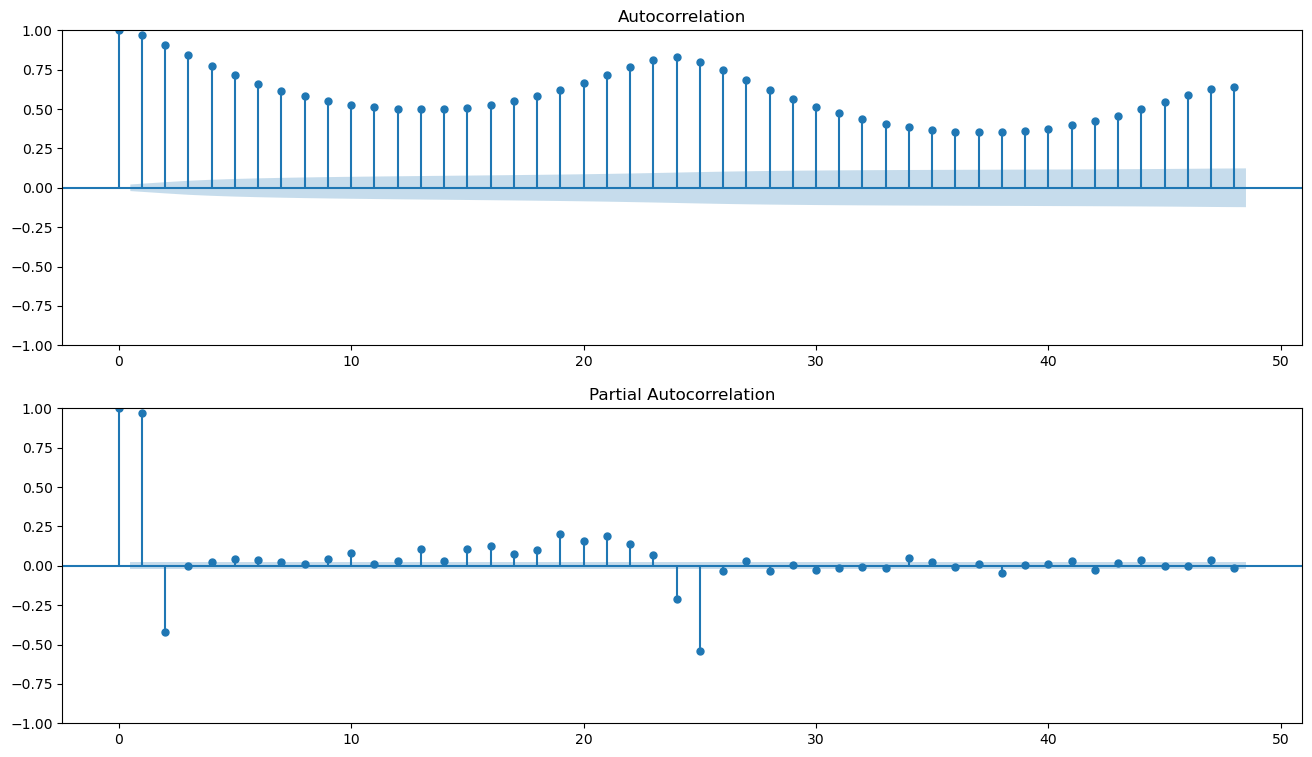

In [22]:
fix,axs = plt.subplots(2,1, figsize=(16,9))
sm.graphics.tsa.plot_acf(df['lbmp'], lags=48, ax=axs[0])
sm.graphics.tsa.plot_pacf(df['lbmp'], lags=48, method="ywm", ax=axs[1])
plt.show()

Again, clearly see the corellation with the 24th hour. **BUT also with the 1st and 2nd lag value.**

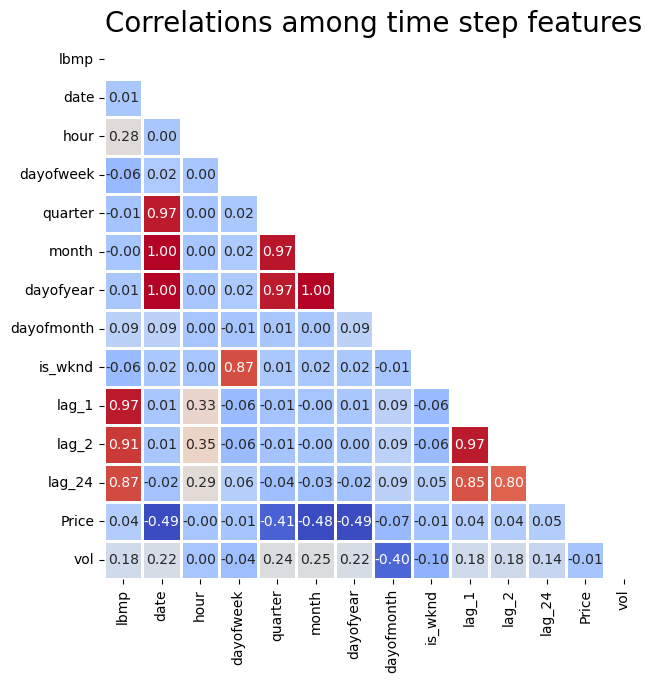

In [23]:
df_corr = df[['lbmp', 'date', 'hour', 'dayofweek', 'quarter',
       'month', 'dayofyear', 'dayofmonth', 'is_wknd', 'lag_1', 'lag_2',
       'lag_24', 'Price', 'vol']].corr(numeric_only=False)
mask = np.triu(df_corr)
plt.figure(figsize=(7, 7))
sns.heatmap(df_corr,
        annot=True,
        fmt='.2f',
        cmap='coolwarm',
        square=True,
        mask=mask,
        linewidths=1,
        cbar=False)
plt.title("Correlations among time step features",fontsize = 20)
plt.show()

# Model

The forecasting model choice. I would like to compare multiple approaches:
- SARIMAX - seasonal ARIMA with exogeneous features
- Time step and lag features XGBOOST model
- Facebook Prophet library - kind of auto-ml library for forecasting to see how the first two models compare with it

**NOTE:** We could use the decomposed series (trend, seasonal, residuals) to model each part separately, which is often better, but I choose to use the whole series for the demo.

In [24]:
df.head()

LBMP ($/MWHr)  Price      vol   lbmp                date  \
ts                                                                              
2017-01-02 00:00:00          36.16    3.5  175.525  36.16 2017-01-02 00:00:00   
2017-01-02 01:00:00          35.07    3.5  175.525  35.07 2017-01-02 01:00:00   
2017-01-02 02:00:00          30.14    3.5  175.525  30.14 2017-01-02 02:00:00   
2017-01-02 03:00:00          27.35    3.5  175.525  27.35 2017-01-02 03:00:00   
2017-01-02 04:00:00          29.90    3.5  175.525  29.90 2017-01-02 04:00:00   

                     hour  dayofweek  quarter  month  dayofyear  dayofmonth  \
ts                                                                            
2017-01-02 00:00:00     0          0        1      1          2           2   
2017-01-02 01:00:00     1          0        1      1          2           2   
2017-01-02 02:00:00     2          0        1      1          2           2   
2017-01-02 03:00:00     3          0        1      1          2           2   
2017-01-02 04:00:00     4          0        1      1          2           2   

                     is_wknd  lag_1  lag_2  lag_24  sin(1,freq=H)  \
ts                                                                  
2017-01-02 00:00:00        0  29.81  31.84   33.60            0.0   
2017-01-02 01:00:00        0  36.16  29.81   32.05            0.0   
2017-01-02 02:00:00        0  35.07  36.16   29.23            0.0   
2017-01-02 03:00:00        0  30.14  35.07   25.02            0.0   
2017-01-02 04:00:00        0  27.35  30.14   26.94            0.0   

                     cos(1,freq=H)  sin(2,freq=H)  cos(2,freq=H)  \
ts                                                                 
2017-01-02 00:00:00            1.0            0.0            1.0   
2017-01-02 01:00:00            1.0            0.0            1.0   
2017-01-02 02:00:00            1.0            0.0            1.0   
2017-01-02 03:00:00            1.0            0.0            1.0   
2017-01-02 04:00:00            1.0            0.0            1.0   

                     sin(3,freq=H)  cos(3,freq=H)  sin(4,freq=H)  \
ts                                                                 
2017-01-02 00:00:00            0.0            1.0            0.0   
2017-01-02 01:00:00            0.0            1.0            0.0   
2017-01-02 02:00:00            0.0            1.0            0.0   
2017-01-02 03:00:00            0.0            1.0            0.0   
2017-01-02 04:00:00            0.0            1.0            0.0   

                     cos(4,freq=H)  const  
ts                                         
2017-01-02 00:00:00            1.0    1.0  
2017-01-02 01:00:00            1.0    1.0  
2017-01-02 02:00:00            1.0    1.0  
2017-01-02 03:00:00            1.0    1.0  
2017-01-02 04:00:00            1.0    1.0

## Multistep forecast

**Our goal is to forecast 24 hours ahead = 24 steps ahead. There are several strategies how to forecast multiple steps ahead, e.g. recursive prediction with previous result, separate model for each step, ...**

**The main issue is to not leak future info to the models, e.g. use the real values for the lagged features... when predicting multiple steps ahead. The recursive strategy means that we predict step by step and use the previous prediction as basis to calculate the dependant features (e.g. lagged features of the lbmp).**

**At first I will use just the day 2017-08-01 as a test sample and show the results. Later I will perform evaluation with cross validation with more than just 1 day test sample**

In [25]:
df['train'] = df.index<dtest
df = df[df.index < dtest+pd.Timedelta('24H')].copy()

In [26]:
df[df['train']].shape, df[~df['train']].shape

((5064, 25), (24, 25))

## SARIMAX

In [27]:
sarima1 = SarimaWrap(exog_features=['Price', 'vol'], order = (2,0,0), seasonal_order=(1,0,0,24), trend="c")
X = sarima1.get_X(df.loc[df['train']])
Y = df.loc[df['train'],'lbmp']
sarima1.fit(X,Y)

C:\datascience\python\envs\bpp\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



sarima

In [28]:
sarima1.m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                               lbmp   No. Observations:                 5064
Model:             SARIMAX(2, 0, 0)x(1, 0, 0, 24)   Log Likelihood              -11893.271
Date:                            Sun, 12 Feb 2023   AIC                          23800.541
Time:                                    23:02:16   BIC                          23846.251
Sample:                                01-02-2017   HQIC                         23816.551
                                     - 07-31-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.8835      0.110      8.016      0.000       0.667       1.100
Price         -3.4585      1.333     -2.595      0.009      -6.071      -0.846
vol            0.0093      0.002      3.846      0.000       0.005       0.014
ar.L1          1.0920      0.009    125.430      0.000       1.075       1.109
ar.L2         -0.1650      0.010    -17.168      0.000      -0.184      -0.146
ar.S.L24       0.7187      0.007    109.364      0.000       0.706       0.732
sigma2         6.3945      0.063    102.061      0.000       6.272       6.517
===================================================================================
Ljung-Box (L1) (Q):                   0.32   Jarque-Bera (JB):             10395.05
Prob(Q):                              0.57   Prob(JB):                         0.00
Heteroskedasticity (H):               1.35   Skew:                             0.63
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [29]:
Xtest = sarima1.get_X(df.loc[~df['train']])
pred = sarima1.rolling_predict(Xtest)

In [30]:
df['sarima'] = np.concatenate((sarima1.m.fittedvalues.values, pred))

In [31]:
evaluate(df.loc[~df['train'],'lbmp'],df.loc[~df['train'],'sarima'])

mae     5.880641
mse    86.360319
dtype: float64

## REG xgboost

In [32]:
xgbmod = XgbWrap(feature_cols=feature_cols, n_estimators=100, max_depth=9)
X = xgbmod.get_X(df.loc[df['train']])
Y = df.loc[df['train'],'lbmp']
xgbmod.fit(X,Y)

XGB

In [33]:
Xtest = xgbmod.get_X(df.loc[~df['train']])
pred = xgbmod.rolling_predict(Xtest)

In [34]:
df['regxgb'] = np.concatenate((xgbmod.m.predict(X), pred))

In [35]:
evaluate(df.loc[~df['train'],'lbmp'],df.loc[~df['train'],'regxgb'])

mae      8.490910
mse    105.478298
dtype: float64

## Fb prophet

In [36]:
prophetmod = ProphetWrap(datetime_col='date', target_col='lbmp')
X = prophetmod.get_X(df.loc[df['train']])
Y = None
prophetmod.fit(X,Y)

23:02:17 - cmdstanpy - INFO - Chain [1] start processing
23:02:18 - cmdstanpy - INFO - Chain [1] done processing


In [37]:
Xtest = prophetmod.get_X(df.loc[~df['train']])
pred = prophetmod.rolling_predict(Xtest)

In [38]:
df['prophet'] = np.concatenate((prophetmod.m.predict()['yhat'], pred))

In [39]:
evaluate(df.loc[~df['train'],'lbmp'],df.loc[~df['train'],'prophet'])

mae     7.590691
mse    87.832224
dtype: float64

# Comparison on 1 day test sample (2017-08-01)

In [40]:
plot_df = df.loc["2017-08-01":]
trace = [
    go.Scatter(x=df.loc["2017-07-30":,'date'], y=df.loc["2017-07-30":,'LBMP ($/MWHr)'], name='LBMP', mode='markers'),
    go.Scatter(x=plot_df['date'], y=plot_df['sarima'], name='SARIMA', mode='lines'),
    go.Scatter(x=plot_df['date'], y=plot_df['regxgb'], name='XGBOOST', mode='lines'),
    go.Scatter(x=plot_df['date'], y=plot_df['prophet'], name='PROPHET', mode='lines')
]

fig = go.Figure(data=trace, layout=go.Layout(xaxis_title='Date', yaxis_title='LBMP'))
fig.update_xaxes(rangeslider_visible=True)
fig.update_traces(opacity=0.7)
fig.show()

In [41]:
# fig.write_html("Chart2.html")

In case the above plotly chart is not rendered, look for `Chart2.html` in repository.

# Cross validation

At this point I was satisfied with the models and created a small 'library' with scripts to use the data, preprocess and train the models and get forecast.

I make it so all the different models have the same fit and predict method. This makes it easy to automate training and especially the rolling multi step prediction. Now we can easily perform cross-validation or parameter search e.g. grid search. 

In [42]:
data = read_data(lbmp_dirpath=lbmp_dirpath, gas_filepath=gaspath, zone='N.Y.C.')
df = preprocess_data(data)

feature_cols = ['hour', 'dayofweek', 'quarter',
       'month', 'dayofyear', 'dayofmonth', 'is_wknd', 'lag_1', 'lag_2',
       'lag_24', 'sin(1,freq=H)', 'cos(1,freq=H)', 'sin(2,freq=H)',
       'cos(2,freq=H)', 'sin(3,freq=H)', 'cos(3,freq=H)', 'sin(4,freq=H)',
       'cos(4,freq=H)', 'const', 'Price', 'vol']

In [43]:
models = [
    SarimaWrap(exog_features=['Price', 'vol'], order = (2,0,0), seasonal_order=(1,0,0,24), trend="c"),
    XgbWrap(feature_cols=feature_cols, n_estimators=100, max_depth=9),
    ProphetWrap(datetime_col='date', target_col='lbmp') 
]

In [44]:
cv_results = []
for m in models:
    res = cv(m, df, k=10, target_col='lbmp', include_diff=True, periods=24)
    res['name'] = m.name
    cv_results.append(res)

cv_results=pd.concat(cv_results,axis=0)  

C:\datascience\python\envs\bpp\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\datascience\python\envs\bpp\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\datascience\python\envs\bpp\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: C:\Users\Matus\AppData\Local\Temp\tmp2avgcd32\6e4019xj.json
DEBUG:cmdstanpy:input tempfile: C:\Users\Matus\AppData\Local\Temp\tmp2avgcd32\ulry_74f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args:

23:07:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:07:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: C:\Users\Matus\AppData\Local\Temp\tmp2avgcd32\1j9k26uh.json
DEBUG:cmdstanpy:input tempfile: C:\Users\Matus\AppData\Local\Temp\tmp2avgcd32\pa00i5vm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\datascience\\python\\envs\\bpp\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=50268', 'data', 'file=C:\\Users\\Matus\\AppData\\Local\\Temp\\tmp2avgcd32\\1j9k26uh.json', 'init=C:\\Users\\Matus\\AppData\\Local\\Temp\\tmp2avgcd32\\pa00i5vm.json', 'output', 'file=C:\\Users\\Matus\\AppD

## Metrics by model

In [45]:
cv_results.groupby('name')[['mae','mse']].mean()

mae        mse
name                        
Prophet  5.009514  41.067620
XGB      4.478446  43.094922
sarima   4.313132  39.615332

## Error by hour in the future

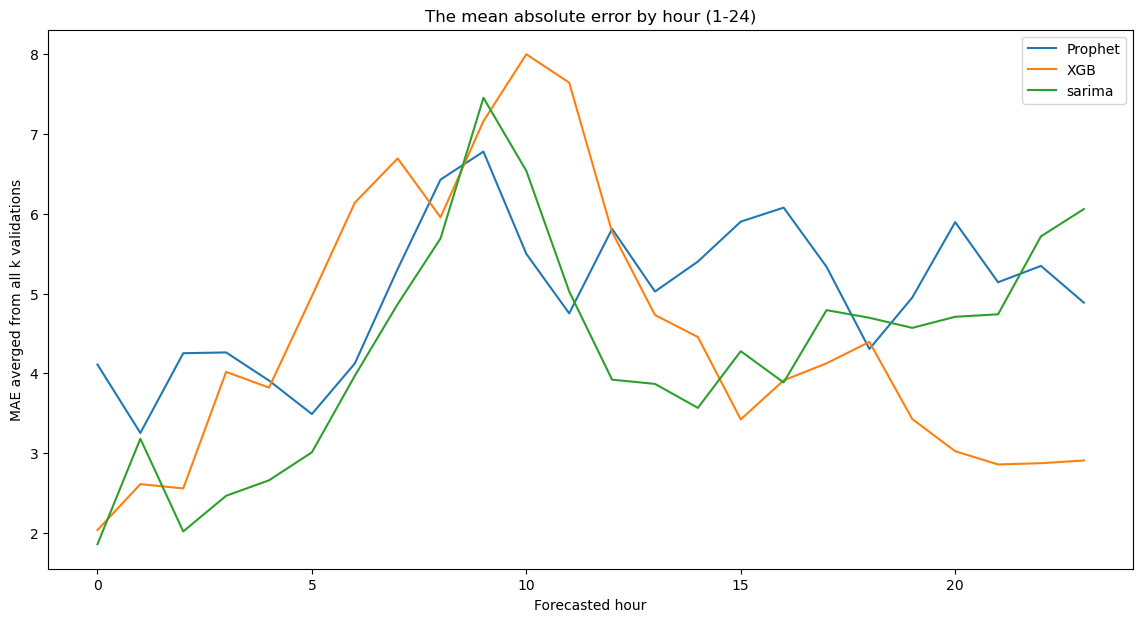

In [46]:
fig, ax = plt.subplots(figsize=(14,7))

t = np.arange(24)

for name, groupdf in cv_results.groupby('name'):
    maes = np.mean(np.abs(np.vstack(groupdf['diff'])),axis=0)
    ax.plot(t,maes, label = name)

plt.title("The mean absolute error by hour (1-24)")
plt.xlabel("Forecasted hour")
plt.ylabel("MAE averged from all k validations")
plt.legend()
plt.show()

# Conclusion & Improvements

To conclude I performed:
- use the provided data and also some example of external dataset - Gas Prices
- performed basic EDA to asses the data and preprocess them
- implemented feature engineering - time step, lag, furier features
- Analyzed the seasonality of the data by decomposition into trend, season and residuals (and plotted the decomposition)
- Analyzed the autocorrelation with ACF and PACF charts to find the best order for the ARIMA model
- Experimented with 3 models - SARIMAX, XGBOOST, FBProphet
- Compared the predictions of the models for the day 2017-08-01 as per the assignment
- Created library with the wrappers for the model capable to do rolling prediction (recursive multistep prediction)
- Performed customized cross-validation and showed some aggregated metrics per model